<a href="https://colab.research.google.com/github/Mymisou/Scrib/blob/master/st_train_dinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import AutoImageProcessor, AutoModelForImageClassification

import matplotlib.pyplot as plt
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

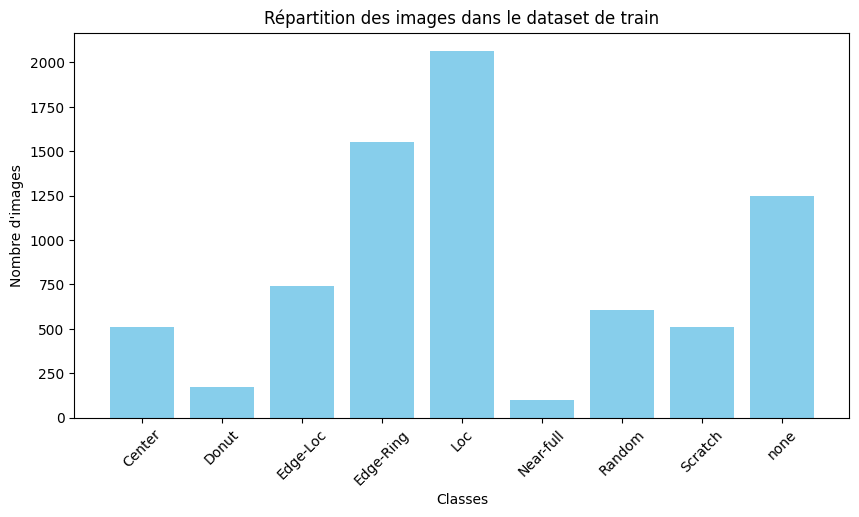

In [ ]:
# Charger le dataset
train_dataset = ImageFolder(root='/content/drive/MyDrive/wafers/v2/train', transform=transform)

# Obtenir les classes et le nombre d'images par classe
class_counts = Counter(train_dataset.targets)
classes = list(train_dataset.class_to_idx.keys())
counts = [class_counts[i] for i in range(len(classes))]

# Plotter la répartition
plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Répartition des images dans le dataset de train')
plt.xticks(rotation=45)
plt.show()


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_dataset.classes))

9


In [9]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base', do_rescale=False)
model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-base', num_labels=len(train_dataset.classes)).to('cuda')  # Move model to GPU

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VERSION1

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
epochs = 15

In [ ]:
# Fine-tuning loop
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        inputs = processor(images=images, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels.to('cuda'))  # Move labels to GPU
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}')

print('Fine-tuning complete!')

KeyboardInterrupt: 

In [ ]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Mixed precision training
scaler = GradScaler()

# Fine-tuning loop with gradient accumulation
accumulation_steps = 4

<ipython-input-24-ddd2575eceed>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/117 [00:00<?, ?it/s]<ipython-input-27-388a3c23d7d2>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 117/117 [01:38<00:00,  1.19it/s]


Epoch [1/10], Loss: 0.5878, Accuracy: 44.01%


100%|██████████| 117/117 [01:31<00:00,  1.28it/s]


Epoch [2/10], Loss: 0.2706, Accuracy: 52.77%


100%|██████████| 117/117 [01:30<00:00,  1.29it/s]


Epoch [3/10], Loss: 0.2519, Accuracy: 56.21%


100%|██████████| 117/117 [01:30<00:00,  1.30it/s]


Epoch [4/10], Loss: 0.2292, Accuracy: 61.80%


100%|██████████| 117/117 [01:30<00:00,  1.30it/s]


Epoch [5/10], Loss: 0.2197, Accuracy: 63.68%


100%|██████████| 117/117 [01:30<00:00,  1.29it/s]


Epoch [6/10], Loss: 0.2156, Accuracy: 64.81%


100%|██████████| 117/117 [01:29<00:00,  1.30it/s]


Epoch [7/10], Loss: 0.2072, Accuracy: 66.59%


100%|██████████| 117/117 [01:29<00:00,  1.31it/s]


Epoch [8/10], Loss: 0.2055, Accuracy: 67.74%


100%|██████████| 117/117 [01:29<00:00,  1.30it/s]


Epoch [9/10], Loss: 0.2051, Accuracy: 67.31%


100%|██████████| 117/117 [01:29<00:00,  1.30it/s]


Epoch [10/10], Loss: 0.2033, Accuracy: 68.52%


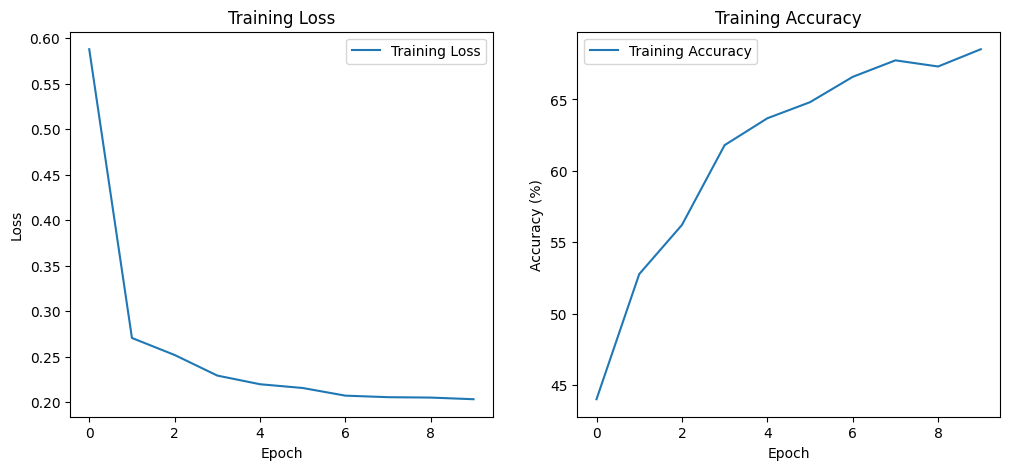

In [ ]:
for epoch in range(25):  # Number of epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        with autocast():
            inputs = processor(images=images, return_tensors="pt").to('cuda')
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels.to('cuda'))
            loss = loss / accumulation_steps  # Normalize loss
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Save the model at each epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_dinov2_model_epoch_{epoch+1}.pth')

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()


In [ ]:
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        with autocast():
            inputs = processor(images=images, return_tensors="pt").to('cuda')
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels.to('cuda'))
            loss = loss / accumulation_steps  # Normalize loss
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()

    scheduler.step()
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}')

  0%|          | 0/116 [00:00<?, ?it/s]<ipython-input-13-25d290d7db81>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 116/116 [15:58<00:00,  8.26s/it]


Epoch [1/10], Loss: 0.292176424686251


100%|██████████| 116/116 [01:28<00:00,  1.32it/s]


Epoch [2/10], Loss: 0.254604484885931


100%|██████████| 116/116 [01:28<00:00,  1.30it/s]


Epoch [3/10], Loss: 0.25449252668125877


100%|██████████| 116/116 [01:33<00:00,  1.24it/s]


Epoch [4/10], Loss: 0.23449125847425953


100%|██████████| 116/116 [01:28<00:00,  1.30it/s]


Epoch [5/10], Loss: 0.22773807213224215


100%|██████████| 116/116 [01:30<00:00,  1.29it/s]


Epoch [6/10], Loss: 0.2247881766023307


100%|██████████| 116/116 [01:27<00:00,  1.33it/s]


Epoch [7/10], Loss: 0.21984095408998686


100%|██████████| 116/116 [01:27<00:00,  1.32it/s]


Epoch [8/10], Loss: 0.21918578805594607


100%|██████████| 116/116 [01:28<00:00,  1.31it/s]


Epoch [9/10], Loss: 0.2184247189554675


100%|██████████| 116/116 [01:27<00:00,  1.33it/s]

Epoch [10/10], Loss: 0.2176517946966763


VERSION 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# Lists to store loss and accuracy
train_losses = []
train_accuracies = []

In [6]:
# Data transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

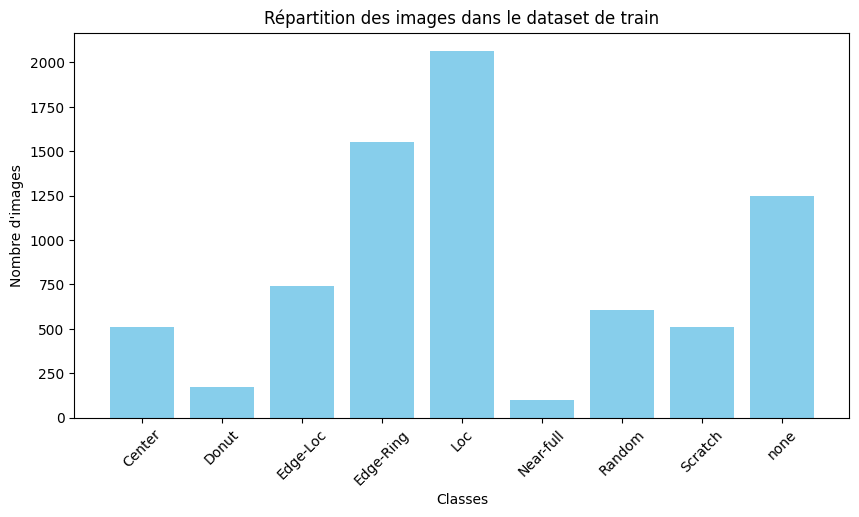

In [7]:
# Charger le dataset
train_dataset = ImageFolder(root='/content/drive/MyDrive/wafers/v2/train', transform=transform)

# Obtenir les classes et le nombre d'images par classe
class_counts = Counter(train_dataset.targets)
classes = list(train_dataset.class_to_idx.keys())
counts = [class_counts[i] for i in range(len(classes))]

# Plotter la répartition
plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Répartition des images dans le dataset de train')
plt.xticks(rotation=45)
plt.show()


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_dataset.classes))

9


In [11]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base', do_rescale=False)
model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-base', num_labels=len(train_dataset.classes)).to('cuda')  # Move model to GPU

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

In [13]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Mixed precision training
scaler = GradScaler()

# Fine-tuning loop with gradient accumulation
accumulation_steps = 4

epochs = 15

<ipython-input-13-3864fd796f36>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [14]:
for epoch in range(epochs):  # Number of epochs
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        with autocast():
            inputs = processor(images=images, return_tensors="pt").to('cuda')
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels.to('cuda'))
            loss = loss / accumulation_steps  # Normalize loss
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/ {epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Save the model at each epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/models/finetuned_dinov2_model_epoch_{epoch+1}_02092025.pth')


  0%|          | 0/235 [00:00<?, ?it/s]<ipython-input-14-408ebe721feb>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 235/235 [2:04:32<00:00, 31.80s/it]


Epoch [1/ 15], Loss: 0.6141, Accuracy: 35.02%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [2/ 15], Loss: 0.3278, Accuracy: 54.34%


100%|██████████| 235/235 [03:01<00:00,  1.30it/s]


Epoch [3/ 15], Loss: 0.2769, Accuracy: 59.46%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [4/ 15], Loss: 0.2435, Accuracy: 63.88%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [5/ 15], Loss: 0.2302, Accuracy: 65.12%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [6/ 15], Loss: 0.2257, Accuracy: 65.61%


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


Epoch [7/ 15], Loss: 0.2219, Accuracy: 66.16%


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


Epoch [8/ 15], Loss: 0.2228, Accuracy: 65.85%


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


Epoch [9/ 15], Loss: 0.2220, Accuracy: 66.25%


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


Epoch [10/ 15], Loss: 0.2200, Accuracy: 66.89%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [11/ 15], Loss: 0.2190, Accuracy: 66.69%


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


Epoch [12/ 15], Loss: 0.2193, Accuracy: 66.93%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [13/ 15], Loss: 0.2198, Accuracy: 66.54%


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


Epoch [14/ 15], Loss: 0.2183, Accuracy: 66.84%


100%|██████████| 235/235 [03:01<00:00,  1.30it/s]


Epoch [15/ 15], Loss: 0.2222, Accuracy: 65.94%


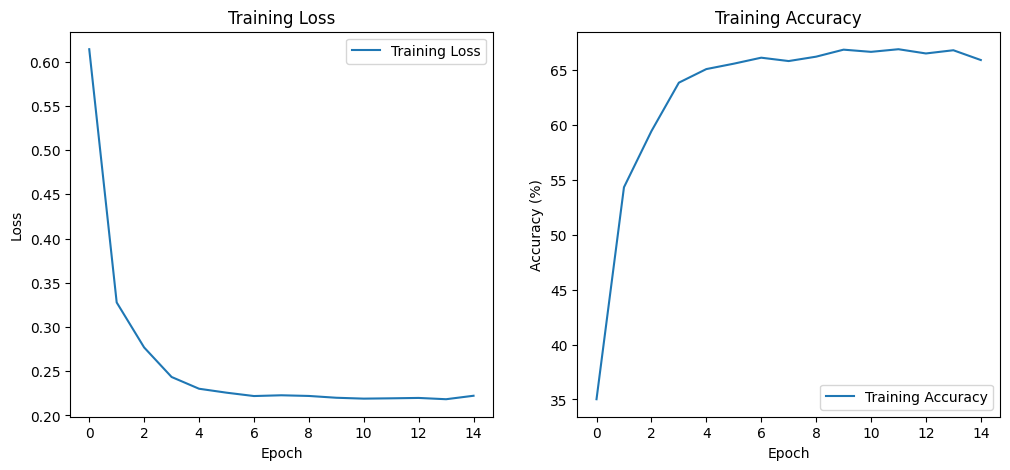

In [15]:
# Plotting the results
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

## Evaluate model

<ipython-input-21-43499514c2a6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/models/finetuned_dinov2_model_epoch

Classification Report:
               precision    recall  f1-score   support

      Center       0.00      0.00      0.00        10
       Donut       1.00      0.40      0.57        10
    Edge-Loc       0.00      0.00      0.00        10
   Edge-Ring       0.89      0.80      0.84        10
         Loc       0.11      1.00      0.20         3
   Near-full       1.00      0.67      0.80         3
      Random       0.75      1.00      0.86         3
     Scratch       0.00      0.00      0.00        10
        none       0.21      1.00      0.35         3

    accuracy                           0.37        62
   macro avg       0.44      0.54      0.40        62
weighted avg       0.41      0.37      0.33        62



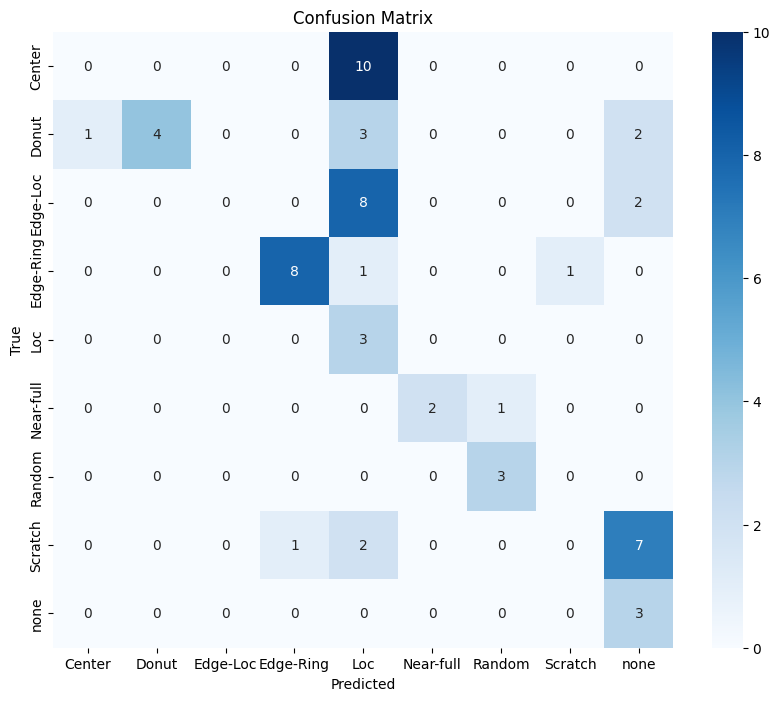

In [21]:
model = AutoModelForImageClassification.from_pretrained('facebook/dinov2-base', num_labels=len(train_dataset.classes)).to('cuda')
 Load the state dictionary into the model
model.load_state_dict(torch.load('/content/drive/MyDrive/models/finetuned_dinov2_model_epoch_12_02092025.pth'))
model.eval()

# Transformer pour le dataset de test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Charger le dataset de test
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/wafers/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation du modèle
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        inputs = processor(images=images, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        _, preds = torch.max(outputs.logits, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

# Rapport de classification
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
print("Classification Report:\n", report)

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()